## DCGAN
Here are the main features of DCGAN (don't worry about memorizing these, you will be guided through the implementation!): 

<!-- ```
Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
• Use BatchNorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
``` -->


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

You will begin by importing some useful packages and data that will help you create your GAN. You are also provided a visualizer function to help see the images your GAN will create.

In [11]:
import torch
from torch import nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor_real, image_tensor_fake, num_iamges=25, size=(1,28,28)):
    image_tensor = (image_tensor_real+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_iamges], nrow=5)
    real_img = image_grid.permute(1,2,0).squeeze()

    image_tensor = (image_tensor_fake+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_iamges], nrow=5)
    fake_img = image_grid.permute(1,2,0).squeeze()
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(real_img)
    f.add_subplot(1,2, 2)
    plt.imshow(fake_img)
    plt.show(block=True)

## Generator
The first component you will make is the generator. You may notice that instead of passing in the image dimension, you will pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, you will need to write a function to create a single block for the generator's neural network.
<!-- From the paper, we know to "[u]se batchnorm in both the generator and the discriminator" and "[u]se ReLU activation in generator for all layers except for the output, which uses Tanh." --> 
Since in DCGAN the activation function will be different for the output layer, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!

At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network. You are also given a function to create a noise vector. These functions are the same as the ones from the last assignment.


In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim*4),
            self.make_gen_block(hidden_dim*4, hidden_dim*2, kernel_size = 4, stride=1),
            self.make_gen_block(hidden_dim*2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan,  kernel_size=4, final_layer=True)
        )


    
    def make_gen_block(self, input_channels, output_channels, kernel_size = 3, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),               
                nn.Tanh())
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU())
    
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)
    



## Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.
<!-- From the paper, we know that we need to "[u]se LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN. -->
There are also tests at the end for you to use.


In [18]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super().__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim*2),
            self.make_disc_block(hidden_dim*2, 1, final_layer=True))

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride))
        else: 
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2))
    
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)
        

## Training
Now you can put it all together!
Remember that these are your parameters:
  *   `criterion:` the loss function
  *   `n_epochs:` the number of times you iterate through the entire dataset when training
  *   `z_dim:` the dimension of the noise vector
  *   `display_step:` how often to display/visualize the images
  *   `batch_size:` the number of images per forward/backward pass
  *   `lr:` the learning rate
  *   `beta_1, beta_2:` the momentum term
  *   `device:` the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->

In [19]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from IPython.display import clear_output

criterion = nn.BCEWithLogitsLoss()

# Configuraing Hyperparameters
z_dim = 64
display_step =500
batch_size = 128
lr = 1e-4

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

dataloader = DataLoader(MNIST('.', download=True, transform=transform),
                        batch_size = batch_size,
                        shuffle = True)

clear_output()

### Initializing the Models:


In [20]:
gen = Generator(z_dim).to(device)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr = lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta_1, beta_2))

# custom weights initializer for the 
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# Training Models:

Epoch: 1, step: 500, Gen Loss: 0.7306228300333024, Disc Loss: 0.6006876379847527


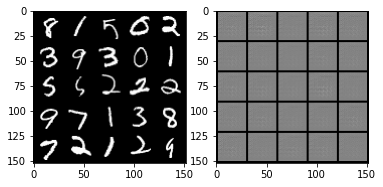

Epoch: 2, step: 1000, Gen Loss: 1.2653823705911644, Disc Loss: 0.3003715795576572


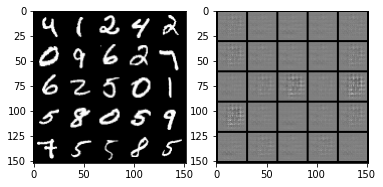

Epoch: 3, step: 1500, Gen Loss: 2.182645790338518, Disc Loss: 0.11779089420288812


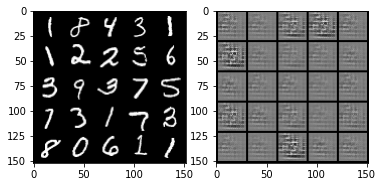

Epoch: 4, step: 2000, Gen Loss: 2.792310000956059, Disc Loss: 0.11151416134089231


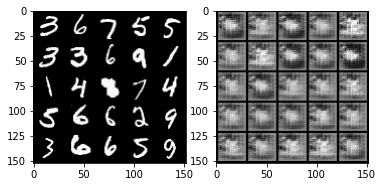

Epoch: 5, step: 2500, Gen Loss: 1.9534968993663795, Disc Loss: 0.2901338721811768


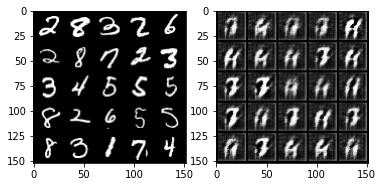

Epoch: 6, step: 3000, Gen Loss: 1.357881219774484, Disc Loss: 0.45364412766695017


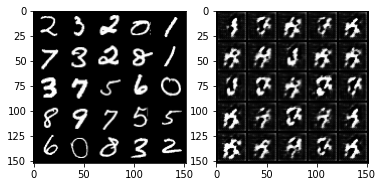

Epoch: 7, step: 3500, Gen Loss: 1.0506919450759888, Disc Loss: 0.5254106690287588


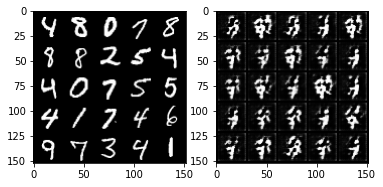

Epoch: 8, step: 4000, Gen Loss: 0.9683958258032804, Disc Loss: 0.5772851372957231


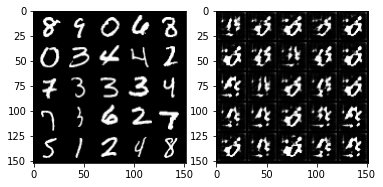

Epoch: 9, step: 4500, Gen Loss: 0.9410662943124778, Disc Loss: 0.586586750924587


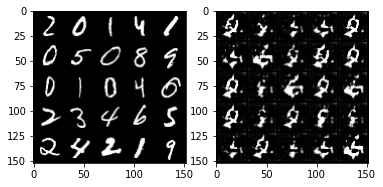

Epoch: 10, step: 5000, Gen Loss: 0.9140293334722516, Disc Loss: 0.591000396370888


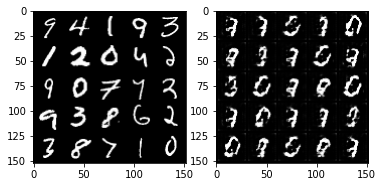

Epoch: 11, step: 5500, Gen Loss: 0.9360685349702831, Disc Loss: 0.5949302962422373


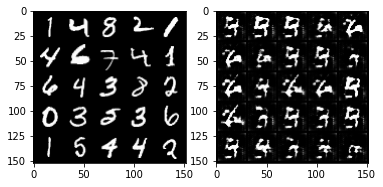

Epoch: 12, step: 6000, Gen Loss: 0.8892882539033884, Disc Loss: 0.6020189548730851


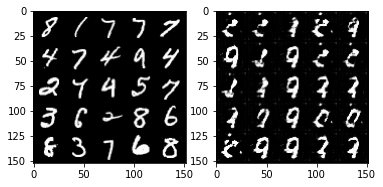

Epoch: 13, step: 6500, Gen Loss: 0.9119566688537599, Disc Loss: 0.5898118500113487


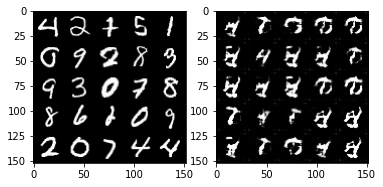

Epoch: 14, step: 7000, Gen Loss: 0.9034952263832097, Disc Loss: 0.5956065509319304


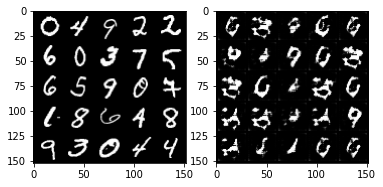

Epoch: 15, step: 7500, Gen Loss: 0.8723762016296396, Disc Loss: 0.6154499074220655


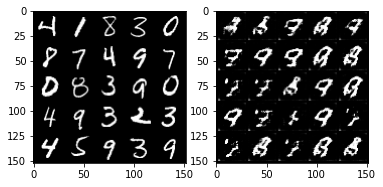

Epoch: 17, step: 8000, Gen Loss: 0.914010713458061, Disc Loss: 0.5934215813279147


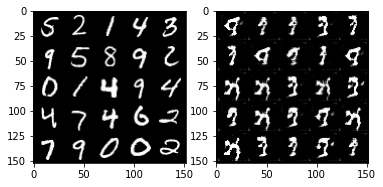

Epoch: 18, step: 8500, Gen Loss: 0.9892737050652494, Disc Loss: 0.5650825316309928


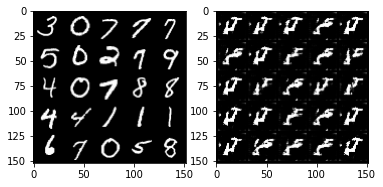

Epoch: 19, step: 9000, Gen Loss: 1.0764462205767649, Disc Loss: 0.5304722653627394


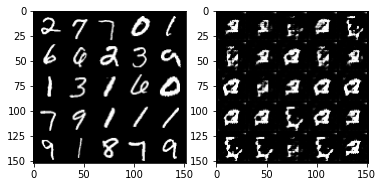

Epoch: 20, step: 9500, Gen Loss: 0.9962005568742749, Disc Loss: 0.5609317815303803


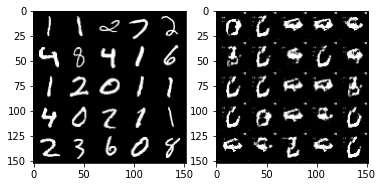

Epoch: 21, step: 10000, Gen Loss: 1.0037018755674372, Disc Loss: 0.5697436661124229


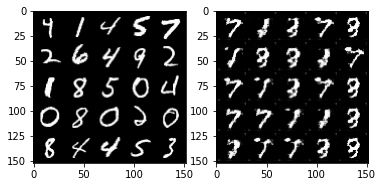

Epoch: 22, step: 10500, Gen Loss: 1.0403886424899105, Disc Loss: 0.5342721196413038


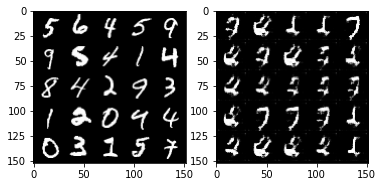

Epoch: 23, step: 11000, Gen Loss: 1.0622278470993043, Disc Loss: 0.5457611892223355


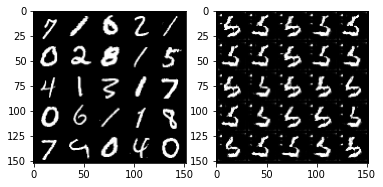

Epoch: 24, step: 11500, Gen Loss: 1.1928708922862987, Disc Loss: 0.4703263538479806


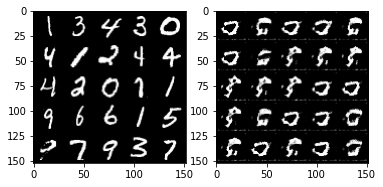

Epoch: 25, step: 12000, Gen Loss: 1.1652016301155093, Disc Loss: 0.4962863461375236


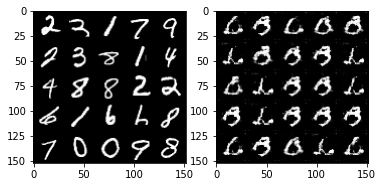

Epoch: 26, step: 12500, Gen Loss: 1.1857987354993822, Disc Loss: 0.4980348187088961


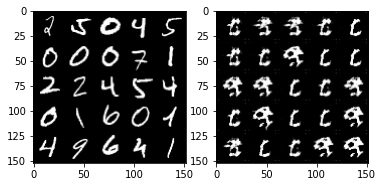

Epoch: 27, step: 13000, Gen Loss: 1.2714747887849807, Disc Loss: 0.44553578799963034


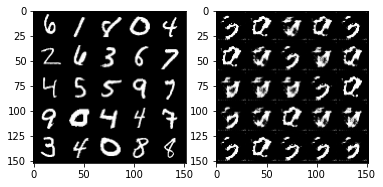

Epoch: 28, step: 13500, Gen Loss: 1.2334665085077272, Disc Loss: 0.4699028418660164


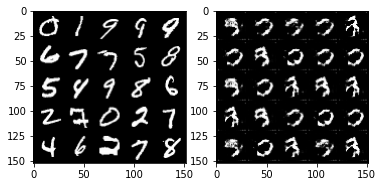

Epoch: 29, step: 14000, Gen Loss: 1.290779170393943, Disc Loss: 0.4488377054333687


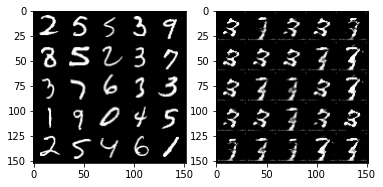

Epoch: 30, step: 14500, Gen Loss: 1.354603483676911, Disc Loss: 0.42059248834848406


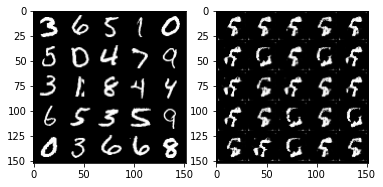

Epoch: 31, step: 15000, Gen Loss: 1.303026153683662, Disc Loss: 0.44732456213235844


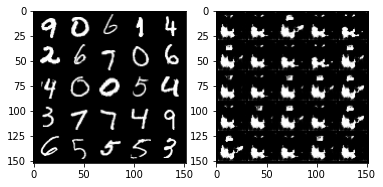

Epoch: 33, step: 15500, Gen Loss: 1.5448410906791665, Disc Loss: 0.34542319099605057


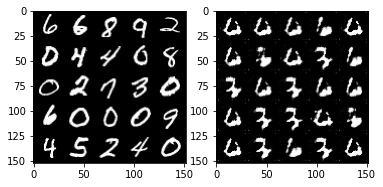

Epoch: 34, step: 16000, Gen Loss: 1.315974094569683, Disc Loss: 0.46460621631145477


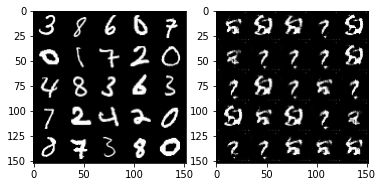

Epoch: 35, step: 16500, Gen Loss: 1.3301962778568257, Disc Loss: 0.42249814277887326


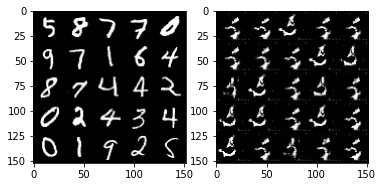

Epoch: 36, step: 17000, Gen Loss: 1.2595175385475161, Disc Loss: 0.48517087471485093


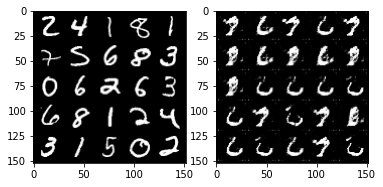

Epoch: 37, step: 17500, Gen Loss: 1.2739490034580228, Disc Loss: 0.442552633464336


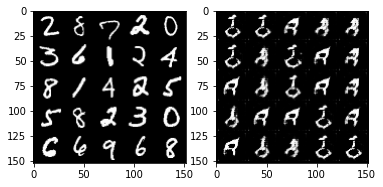

Epoch: 38, step: 18000, Gen Loss: 1.3066133227348324, Disc Loss: 0.45762420576810847


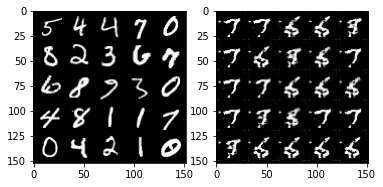

Epoch: 39, step: 18500, Gen Loss: 1.3462639364004134, Disc Loss: 0.4502159478664397


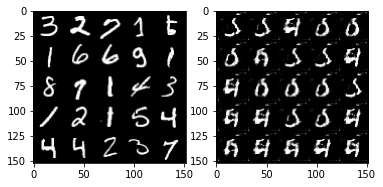

Epoch: 40, step: 19000, Gen Loss: 1.2527698564529428, Disc Loss: 0.49320143789052967


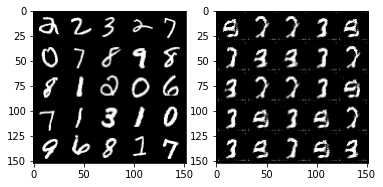

Epoch: 41, step: 19500, Gen Loss: 1.3395325034856802, Disc Loss: 0.4419796703159808


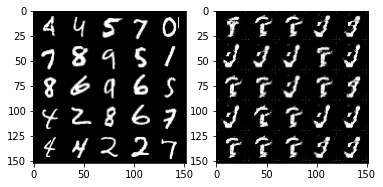

Epoch: 42, step: 20000, Gen Loss: 1.2854917140007005, Disc Loss: 0.4570836957097057


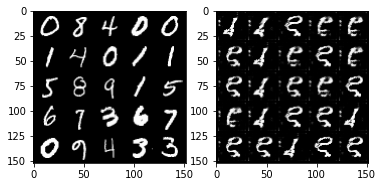

Epoch: 43, step: 20500, Gen Loss: 1.3645867516994488, Disc Loss: 0.4289596266746518


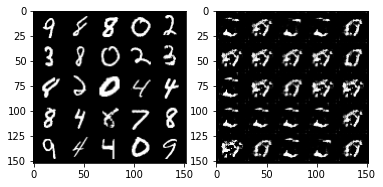

Epoch: 44, step: 21000, Gen Loss: 1.4039556827545168, Disc Loss: 0.424242387354374


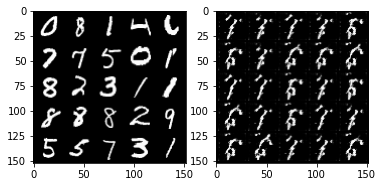

Epoch: 45, step: 21500, Gen Loss: 1.3995500265359877, Disc Loss: 0.4330473240613935


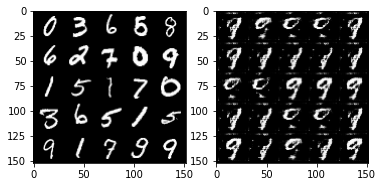

Epoch: 46, step: 22000, Gen Loss: 1.2652912734746922, Disc Loss: 0.47075809025764426


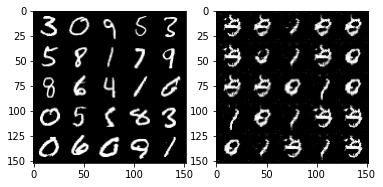

Epoch: 47, step: 22500, Gen Loss: 1.2875667876005172, Disc Loss: 0.4749034388661381


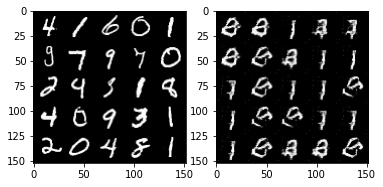

Epoch: 49, step: 23000, Gen Loss: 1.2654792325496678, Disc Loss: 0.4465492623448374


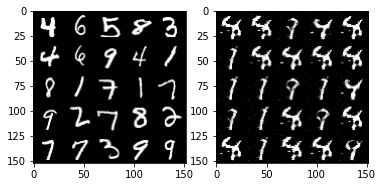

In [22]:
from tqdm.auto import tqdm

n_epochs = 50
cur_step = 0
mean_generator_loss=0
mean_discriminator_loss=0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader, leave=False):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Calculate Discriminator loss
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)/2
        
        ## Update Discriminator
        disc_optimizer.zero_grad()
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        # Calculate Generator Loss
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        # Updating the Generator
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Keeping track of the generator and discriminator losses
        mean_discriminator_loss += disc_loss.item()/display_step
        mean_generator_loss += gen_loss.item()/display_step

        if cur_step % display_step ==0 and cur_step >0:
            print(f'Epoch: {epoch}, step: {cur_step}, Gen Loss: {mean_generator_loss}, Disc Loss: {mean_discriminator_loss}')
            show_tensor_images(real, fake)

            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
